Download Dataset

In [ ]:
import os
os.environ['KAGGLE_USERNAME']   = 'mohammadfahmiaziz'
os.environ['KAGGLE_KEY']        = ''

!kaggle datasets download -d linkgish/indonesian-fact-and-hoax-political-news

import zipfile

zip_ref = zipfile.ZipFile('/content/indonesian-fact-and-hoax-political-news.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

 89% 90.0M/101M [00:01<00:00, 111MB/s] 
100% 101M/101M [00:01<00:00, 90.4MB/s]


## Read and Pre Processing

In [ ]:
## FUNGSI PREPROCESSING
import pandas as pd
import string
import re
from keras.src.utils import pad_sequences
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


def preprocessing(df):
    # Menjadikan huruf kecil
    df['Title'] = df['Title'].str.lower()

    # Fungsi untuk mengganti spasi dengan tanda baca
    def space_to_punct(text):
        for punct in string.punctuation:
            text = text.replace(punct, f' {punct} ')

        text = re.sub(' +', ' ', text)
        return text

    # Mengaplikasikan fungsi space_to_punct ke kolom 'Title'
    df['Title'] = df['Title'].apply(space_to_punct)

    # Fungsi untuk melakukan preprocessing
    def preprocess_text(text):
        # Menghapus angka
        text = re.sub(r"\d+", "", text)
        # Menghapus tanda baca
        text = text.translate(str.maketrans("", "", string.punctuation))
        # Menghapus spasi berlebih
        text = text.strip()
        text = re.sub('\s+', ' ', text)
        return text

    # Mengaplikasikan preprocessing ke kolom 'Title'
    df['Title'] = df['Title'].apply(preprocess_text)

    # Fungsi untuk menghapus karakter dan emotikon
    def remove_special_characters(text):
        # Mengganti karakter yang diinginkan dengan string kosong
        text_cleaned = re.sub("[”“‘’\"″]", "", text)

        # Mengganti emotikon dengan string kosong
        emoticon_pattern = "["
        emoticon_pattern += u"\U0001F600-\U0001F64F"  # Emotikon umum
        emoticon_pattern += u"\U0001F300-\U0001F5FF"  # Simbol & peta
        emoticon_pattern += u"\U0001F680-\U0001F6FF"  # Transportasi & simbol umum
        emoticon_pattern += u"\U0001F700-\U0001F77F"  # Alat & simbol teknis
        emoticon_pattern += u"\U0001F780-\U0001F7FF"  # Alat & seni
        emoticon_pattern += u"\U0001F800-\U0001F8FF"  # Variasi warna
        emoticon_pattern += u"\U0001F900-\U0001F9FF"  # Emoji & simbol tambahan
        emoticon_pattern += u"\U0001FA00-\U0001FA6F"  # Emoji & simbol tambahan
        emoticon_pattern += u"\U0001FA70-\U0001FAFF"  # Emoji & simbol tambahan
        emoticon_pattern += u"\U00002702-\U000027B0"  # Emoji & simbol tambahan
        emoticon_pattern += u"\U000024C2-\U0001F251"
        emoticon_pattern += "]+"
        text_cleaned = re.sub(emoticon_pattern, "", text_cleaned, flags=re.UNICODE)

        return text_cleaned

    # Menggunakan fungsi untuk menghapus karakter dan emotikon dari kolom "title"
    df['Title'] = df['Title'].apply(remove_special_characters)

    # Download stopwords jika belum diunduh
    nltk.download('stopwords')

    # Mengambil stopwords dalam bahasa Indonesia
    list_stopwords = set(stopwords.words('indonesian'))

    # Menghapus stopwords dari setiap kalimat di kolom 'Title'
    df['Title'] = df['Title'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in list_stopwords]))

    return df

## FUNGSI WORDCLOUD
def generate_and_display_wordcloud(data_df, label_value):
    # Filter data berdasarkan label
    filtered_data = data_df[data_df['hoax'] == label_value]

    # Gabungkan semua teks dari kolom 'title' yang memiliki label tertentu menjadi satu teks panjang
    text = " ".join(filtered_data['Title'])

    # Membuat Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

    # Menampilkan Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## FUNGSI TRAIN TEST SPLIT
def split_data(features, labels, test_size=0.2, random_state=42):
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    return x_train,x_test, y_train, y_test

## FUNGSI PLOT AKURASI DAN LOSS
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

## FUNGSI EVALUATE DAN CONFUSSION MATRIX
def evaluate_and_visualize(model, x_train, y_train, X_test, y_test):
    # Print accuracy on training and testing data
    train_accuracy = model.evaluate(x_train, y_train)[1] * 100
    test_accuracy = model.evaluate(X_test, y_test)[1] * 100
    print("Accuracy of the model on Training Data is - ", train_accuracy)
    print("Accuracy of the model on Testing Data is - ", test_accuracy)

    # Predictions on test data
    predictions = model.predict(X_test)
    predictions_integer = (predictions > 0.5).astype(int)

    print("Sample Predictions:", predictions_integer[:5])

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, predictions_integer))

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions_integer)
    cm = pd.DataFrame(cm, index=['Real', 'Hoax'], columns=['Real', 'Hoax'])

    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['Real', 'Hoax'],
                yticklabels=['Real', 'Hoax'])
    plt.title('Confusion Matrix')
    plt.show()

## FUNGSI PREDICT TEST KALIMAT
PADDING = 'post'
def predict_sentences(sentences, model, tokenizer, max_len):
    # Tokenize and pad the input sentences
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences, padding=PADDING, maxlen=max_len)

    # Make predictions using the model
    predictions = model.predict(padded)

    print(predictions)

    # Convert predictions to binary labels (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)

    return binary_predictions

In [ ]:
"""# Reading Data"""
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from keras.src.optimizers import Adam
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
# from proses import preprocessing, generate_and_display_wordcloud, split_data, plot_graphs, \
#     evaluate_and_visualize, predict_sentences

fact_df = pd.read_excel('/content/Cleaned/dataset_cnn_10k_cleaned.xlsx')
fact_df = pd.read_excel('/content/Cleaned/dataset_kompas_4k_cleaned.xlsx')
fact_df = pd.read_excel('/content/Cleaned/dataset_tempo_6k_cleaned.xlsx')
#fact_df['Hoax'] = 0

hoax_df = pd.read_excel('/content/Cleaned/dataset_turnbackhoax_10_cleaned.xlsx')
#hoax_df['Hoax'] = 1


print(fact_df)

print(fact_df.dtypes)

print(hoax_df.dtypes)

"""## Cek Kolom"""

print(fact_df.columns)

fact_df = fact_df.drop(columns=['Unnamed: 0','Timestamp','FullText','Tags','Author','Url','text_new'])

print(fact_df)

print(hoax_df)

print(hoax_df.columns)

hoax_df = hoax_df.drop(columns=['Unnamed: 0','Timestamp','FullText','Tags','Author','Url','politik','Narasi','Clean Narasi'])

print(hoax_df)

print(hoax_df[hoax_df['Title'].isna()])

#Menghilangkan kata [SALAH] di judul Hoax
hoax_df = hoax_df[hoax_df['Title'].str.contains(r'\[SALAH\]', regex=True)]
print(hoax_df.head())

print("\nSetelah Remove [SALAH]")
# Menghapus kata '[SALAH]' dari kolom 'Title'
hoax_df['Title'] = hoax_df['Title'].str.replace(r'\[SALAH\]', '',regex=True)
print(hoax_df.head())


#Menghapus Tanda Kutip dari Judul Berita Hoax
# Menghilangkan tanda kutip di awal dan akhir teks dalam kolom 'Title'
print('\nSetelah Remove "" Tanda Kutip')
#hoax_df['Title'] = hoax_df['Title'].str.strip('“”')
hoax_df['Title'] = hoax_df['Title'].str.strip().str.strip('“”')
#hoax_df['Title'] = hoax_df['Title'].str.strip('"')
hoax_df['Title'] = hoax_df['Title'].str.strip().str.strip('""')

print(hoax_df)

print(hoax_df[hoax_df['Title'].str.contains(r'\[SALAH\]', regex=True)])


      Unnamed: 0                                              Title  \
0              0  Ma'ruf Amin akan Saksikan Lagi Timnas Indonesi...   
1              1  Menag Yaqut Canangkan 2022 Sebagai Tahun Toler...   
2              2  Jokowi Ajak Masyarakat Hadapi 2022 dengan Sema...   
3              3  Top Nasional: Strategi Hadapi Omicron, Lemhana...   
4              4  Mulai Tahun Ini, Menteri Tjahjo Kumolo Minta P...   
...          ...                                                ...   
6587        6587  5 Fakta dan Kasak-kusuk Jabatan Gubernur Diusu...   
6588        6588  Komentari soal PDIP Enggan Berkoalisi dengan P...   
6589        6589  Top Nasional: NasDem Bilang Piagam Deklarasi K...   
6590        6590  NasDem Sebut Demokrat Tak Ngotot Sodorkan AHY ...   
6591        6591  Nasdem Soal Rencana Kunjungi PDIP: Kami Tak Me...   

                             Timestamp  \
0      Sabtu, 1 Januari 2022 17:14 WIB   
1      Sabtu, 1 Januari 2022 15:05 WIB   
2      Sabtu, 1 Janua

## Prerocessing Real dan Hoax

In [ ]:
"""# Preprocessing

## FUNGSI PREPROCESSING FIX
"""

# Contoh penggunaan:
fact_df = preprocessing(fact_df)
print(fact_df)

hoax_df = preprocessing(hoax_df)
print(hoax_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                                  Title  hoax
0     ma ruf amin saksikan timnas indonesia vs thail...     0
1                       menag yaqut canangkan toleransi     0
2                jokowi ajak masyarakat hadapi semangat     0
3     top nasional strategi hadapi omicron lemhanas ...     0
4             menteri tjahjo kumolo pns apel pagi senin     0
...                                                 ...   ...
6587  fakta kasak kusuk jabatan gubernur diusulkan d...     0
6588  komentari pdip enggan berkoalisi partai doyan ...     0
6589  top nasional nasdem bilang piagam deklarasi ko...     0
6590  nasdem demokrat ngotot sodorkan ahy cawapres a...     0
6591  nasdem rencana kunjungi pdip memohon bertemu b...     0

[6592 rows x 2 columns]
                                                   Title  hoax
0      anies baswedan aliran krsiten sesat alpha omeg...     1
1      hakim wahyu iman santoso alami kecelakaan tung...     1
2                      gambar megawati pua

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Cek Emoticon

In [ ]:
#Mengecek keberadaan emotikon di dalam kolom "title"
emoticon_pattern = "["
emoticon_pattern += u"\U0001F600-\U0001F64F"  # Emotikon umum
emoticon_pattern += u"\U0001F300-\U0001F5FF"  # Simbol & peta
emoticon_pattern += u"\U0001F680-\U0001F6FF"  # Transportasi & simbol umum
emoticon_pattern += u"\U0001F700-\U0001F77F"  # Alat & simbol teknis
emoticon_pattern += u"\U0001F780-\U0001F7FF"  # Alat & seni
emoticon_pattern += u"\U0001F800-\U0001F8FF"  # Variasi warna
emoticon_pattern += u"\U0001F900-\U0001F9FF"  # Emoji & simbol tambahan
emoticon_pattern += u"\U0001FA00-\U0001FA6F"  # Emoji & simbol tambahan
emoticon_pattern += u"\U0001FA70-\U0001FAFF"  # Emoji & simbol tambahan
emoticon_pattern += u"\U00002702-\U000027B0"  # Emoji & simbol tambahan
emoticon_pattern += u"\U000024C2-\U0001F251"
emoticon_pattern += "]+"

contains_emoticon = hoax_df['Title'].str.contains(emoticon_pattern, flags=re.UNICODE)
print(f"Contains emoticon:\n{hoax_df[contains_emoticon]}")

Contains emoticon:
Empty DataFrame
Columns: [Title, hoax]
Index: []


In [ ]:
contains_emoticon = fact_df['Title'].str.contains(emoticon_pattern, flags=re.UNICODE)
print(f"Contains emoticon:\n{fact_df[contains_emoticon]}")

Contains emoticon:
Empty DataFrame
Columns: [Title, hoax]
Index: []


## Train Test Split untuk Real dan Hoax

### Split Real

In [ ]:
x_train_real, x_test_real, y_train_real, y_test_real = split_data(fact_df['Title'], fact_df['hoax'], test_size=0.2, random_state=42)

print("Jumlah data dalam set pelatihan:", x_train_real.shape[0])
print("Jumlah data dalam set pengujian:", x_test_real.shape[0])

print(x_train_real.shape)
print(x_test_real.shape)
print(y_train_real.shape)
print(y_test_real.shape)

print(x_train_real)

print(x_test_real)

print(y_train_real)

print(y_test_real)

Jumlah data dalam set pelatihan: 5273
Jumlah data dalam set pengujian: 1319
(5273,)
(1319,)
(5273,)
(1319,)
4056    gubernur papua lukas enembe usulkan pemekaran ...
677     ketua pbnu yahya staquf sarankan dialog penund...
2375                  komisi iii dpr bahas ruu penyadapan
4398          safari ganjar kunjungi bali makassar mamuju
2020    pdip serahkan keputusan capres megawati hasto ...
                              ...                        
3772    pemberhentian suharso monoarfa ppp pan semoga ...
5191    pendiri pan bentuk amanat indonesia dukung ani...
5226    respon kritik pdip relawan jokowi acara nusant...
5390    tolak pengesahan rkuhp aji tanah papua gelar a...
860     sambangi surya paloh airlangga hartarto silatu...
Name: Title, Length: 5273, dtype: object
2644            wamenkumham alasan buka draf rkuhp publik
5941    kader pdip getol dorong menteri partai nasdem ...
3101    tolak wacana hadirkan pphn konvensi ketatanega...
932     luhut bicara penundaan pemilu b

### Split Hoax

In [ ]:
x_train_hoax, x_test_hoax, y_train_hoax, y_test_hoax = split_data(hoax_df['Title'], hoax_df['hoax'], test_size=0.2, random_state=42)

print("Jumlah data dalam set pelatihan:", x_train_hoax.shape[0])
print("Jumlah data dalam set pengujian:", x_test_hoax.shape[0])

print(x_train_hoax.shape)
print(x_test_hoax.shape)
print(y_train_hoax.shape)
print(y_test_hoax.shape)

print(x_train_hoax)

print(x_test_hoax)

print(y_train_hoax)

print(y_test_hoax)

Jumlah data dalam set pelatihan: 6420
Jumlah data dalam set pengujian: 1606
(6420,)
(1606,)
(6420,)
(1606,)
2982    berhak terima hadiah cashback voucher pulsa gr...
2443            akun whatsapp wakil bupati bangkalan dana
6408               sertifikasi halal hapus ruu sapu jagat
8109               surat wakalah infra struktur dana haji
8350     aksi ganti presiden bergabung pemberontakan aceh
                              ...                        
5337                                      antena g masker
5510    video kecelakaan maut air terjun uluk til belu...
865                          akun facebook inul daratista
8284                     tangsel siaga pascabentrok ormas
7806                 rizal ramli ri berhutang yield maret
Name: Title, Length: 6420, dtype: object
6018                   sabam sirait meninggal dunia april
3612    pria oregon as dipenjara didenda mengumpulkan ...
3067               parasetamol p mengandung virus machupo
7537                video said aqil sir

### Penggabungan Split Dari Real dan Hoax

In [ ]:
#saya ingin menggabungkan dataset dalam variabel x_train_real dan x_train_hoax dengan kolom Title dalam variabel x_train
x_train = pd.concat([x_train_real.iloc[:], x_train_hoax.iloc[:]], axis=0, ignore_index=True)
x_train

0        gubernur papua lukas enembe usulkan pemekaran ...
1        ketua pbnu yahya staquf sarankan dialog penund...
2                      komisi iii dpr bahas ruu penyadapan
3              safari ganjar kunjungi bali makassar mamuju
4        pdip serahkan keputusan capres megawati hasto ...
                               ...                        
11688                                      antena g masker
11689    video kecelakaan maut air terjun uluk til belu...
11690                         akun facebook inul daratista
11691                     tangsel siaga pascabentrok ormas
11692                 rizal ramli ri berhutang yield maret
Name: Title, Length: 11693, dtype: object

In [ ]:
#saya ingin menggabungkan dataset dalam variabel y_train_real dan y_train_hoax dengan kolom Title dalam variabel y_train
y_train = pd.concat([y_train_real.iloc[:], y_train_hoax.iloc[:]], axis=0, ignore_index=True)
y_train

0        0
1        0
2        0
3        0
4        0
        ..
11688    1
11689    1
11690    1
11691    1
11692    1
Name: hoax, Length: 11693, dtype: int64

In [ ]:
#saya ingin menggabungkan dataset dalam variabel x_test_real dan x_test_hoax dengan kolom Hoax dalam variabel x_test
x_test = pd.concat([x_test_real.iloc[:], x_test_hoax.iloc[:]], axis=0, ignore_index=True)
x_test

0               wamenkumham alasan buka draf rkuhp publik
1       kader pdip getol dorong menteri partai nasdem ...
2       tolak wacana hadirkan pphn konvensi ketatanega...
3       luhut bicara penundaan pemilu buru buru capek ...
4       menanggapi kenaikan harga bbm ketua bem unpad ...
                              ...                        
2920                                    ibukota terkepung
2921                       komedian peppy meninggal dunia
2922                         foto pertemuan alien manusia
2923    ksp jokowi terima dengar aspirasi rakyat demo bbm
2924                      kaesang erina putuskan berpisah
Name: Title, Length: 2925, dtype: object

In [ ]:
y_train.value_counts()

hoax
1    6420
0    5273
Name: count, dtype: int64

In [ ]:
y_test_real.value_counts()

hoax
0    1319
Name: count, dtype: int64

In [ ]:
y_test_hoax.value_counts()

hoax
1    1606
Name: count, dtype: int64

In [ ]:
#saya ingin menggabungkan dataset dalam variabel y_test_real dan y_test_hoax dengan kolom Hoax dalam variabel y_test
y_test = pd.concat([y_test_real.iloc[:], y_test_hoax.iloc[:]], axis=0, ignore_index=True)
y_test

0       0
1       0
2       0
3       0
4       0
       ..
2920    1
2921    1
2922    1
2923    1
2924    1
Name: hoax, Length: 2925, dtype: int64

In [ ]:
y_test.value_counts()

hoax
1    1606
0    1319
Name: count, dtype: int64

## Kombinasi Fact and Hoax

                                                   Title  hoax
0      ma ruf amin saksikan timnas indonesia vs thail...     0
1                        menag yaqut canangkan toleransi     0
2                 jokowi ajak masyarakat hadapi semangat     0
3      top nasional strategi hadapi omicron lemhanas ...     0
4              menteri tjahjo kumolo pns apel pagi senin     0
...                                                  ...   ...
14613                        kayu manis vs kencing manis     1
14614  admin mca tertangkap polisi menikmati makan ba...     1
14615  penyerangan muazin masjid agung pameungpeuk garut     1
14616     kemkominfo help desk registrasi kartu prabayar     1
14617                       jokowi maaf pki keluarga pki     1

[14618 rows x 2 columns]


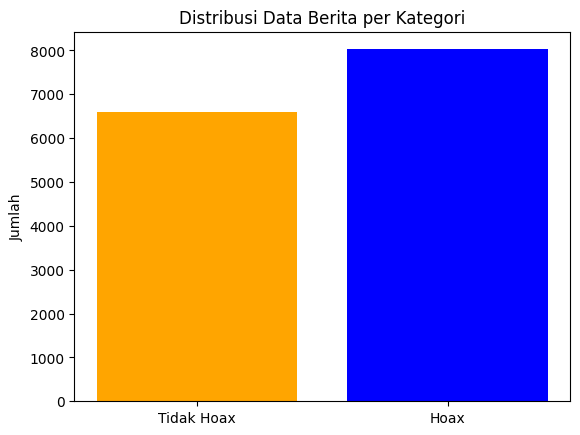

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['Alhamdulillah', ',', 'hari', 'ini', 'cuacanya', 'cerah', '.', 'Tapi', ',', 'sore', 'hari', 'hujan']
Title    object
hoax      int64
dtype: object


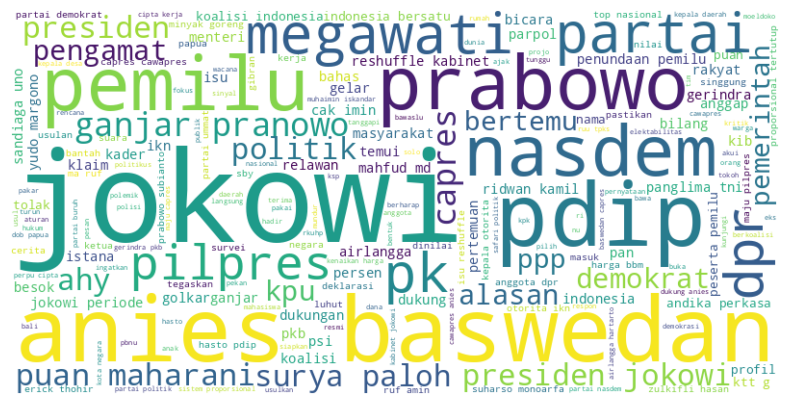

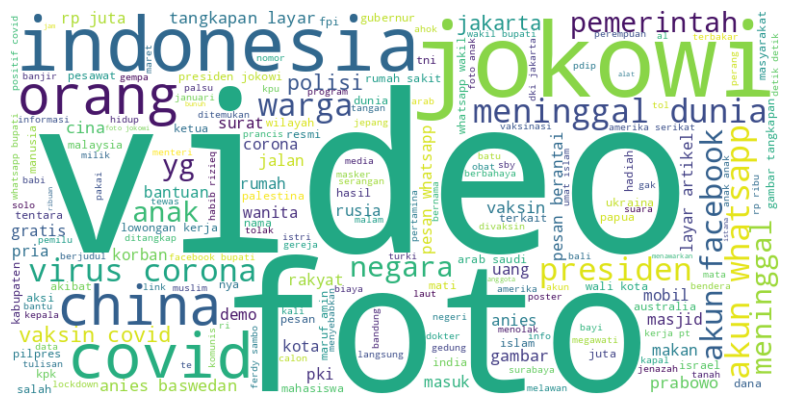

In [ ]:
"""## Kombinasi Fact and Hoax"""

news_df = pd.concat([fact_df.iloc[:], hoax_df.iloc[:]], axis=0, ignore_index=True)
#news_df = pd.concat([fact_df.iloc[:], fact_df1.iloc[:],hoax_df.iloc[:],], axis=0, ignore_index=True)

print(news_df)

"""## Representasi Jumlah Data"""

# Menghitung jumlah angka 0 dan 1 dalam kolom "hoax"
hoax_count = news_df['hoax'].value_counts()

# Warna untuk masing-masing nilai
colors = ['blue', 'orange']

# Membuat diagram batang dengan warna yang berbeda untuk masing-masing nilai
plt.bar(hoax_count.index, hoax_count.values, color=colors)
#plt.xlabel('Hoax')
plt.ylabel('Jumlah')
plt.xticks([0, 1], ['Tidak Hoax', 'Hoax'])
plt.title('Distribusi Data Berita per Kategori')
plt.show()

# download corpus punkt
nltk.download('punkt')

text = "Alhamdulillah, hari ini cuacanya cerah. Tapi, sore hari hujan"
print(word_tokenize(text))

print(news_df.dtypes)

news_df.count()

"""## WordCloud Real , RUN SETELAH REMOVE STOPWORD"""

# Contoh penggunaan fungsi untuk non-hoax
generate_and_display_wordcloud(news_df, label_value=0)

# Contoh penggunaan fungsi untuk hoax
generate_and_display_wordcloud(news_df, label_value=1)

In [ ]:
import pandas as pd

# Misalkan Anda sudah mempunyai DataFrame news_df
# news_df = ...

# Mengecek keberadaan karakter "”", "″", "‘", "’", dan emotikon di dalam kolom "title"
for character in ["”", "″", "‘", "’"]:
    contains_character = news_df['Title'].str.contains(character)
    print(f"Contains '{character}':\n{news_df[contains_character]}")

# Mengecek keberadaan emotikon di dalam kolom "title"
emoticon_pattern = "["
emoticon_pattern += u"\U0001F600-\U0001F64F"  # Emotikon umum
emoticon_pattern += u"\U0001F300-\U0001F5FF"  # Simbol & peta
emoticon_pattern += u"\U0001F680-\U0001F6FF"  # Transportasi & simbol umum
emoticon_pattern += u"\U0001F700-\U0001F77F"  # Alat & simbol teknis
emoticon_pattern += u"\U0001F780-\U0001F7FF"  # Alat & seni
emoticon_pattern += u"\U0001F800-\U0001F8FF"  # Variasi warna
emoticon_pattern += u"\U0001F900-\U0001F9FF"  # Emoji & simbol tambahan
emoticon_pattern += u"\U0001FA00-\U0001FA6F"  # Emoji & simbol tambahan
emoticon_pattern += u"\U0001FA70-\U0001FAFF"  # Emoji & simbol tambahan
emoticon_pattern += u"\U00002702-\U000027B0"  # Emoji & simbol tambahan
emoticon_pattern += u"\U000024C2-\U0001F251"
emoticon_pattern += "]+"

contains_emoticon = news_df['Title'].str.contains(emoticon_pattern, flags=re.UNICODE)
print(f"Contains emoticon:\n{news_df[contains_emoticon]}")


Contains '”':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '″':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '‘':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '’':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains emoticon:
Empty DataFrame
Columns: [Title, hoax]
Index: []


In [ ]:
import pandas as pd
import re

# Misalkan Anda sudah mempunyai DataFrame news_df
# news_df = ...

# Fungsi untuk menghapus karakter dan emotikon
def remove_special_characters(text):
    # Mengganti karakter yang diinginkan dengan string kosong
    text_cleaned = re.sub("[”“‘’\"″]", "", text)

    # Mengganti emotikon dengan string kosong
    emoticon_pattern = "["
    emoticon_pattern += u"\U0001F600-\U0001F64F"  # Emotikon umum
    emoticon_pattern += u"\U0001F300-\U0001F5FF"  # Simbol & peta
    emoticon_pattern += u"\U0001F680-\U0001F6FF"  # Transportasi & simbol umum
    emoticon_pattern += u"\U0001F700-\U0001F77F"  # Alat & simbol teknis
    emoticon_pattern += u"\U0001F780-\U0001F7FF"  # Alat & seni
    emoticon_pattern += u"\U0001F800-\U0001F8FF"  # Variasi warna
    emoticon_pattern += u"\U0001F900-\U0001F9FF"  # Emoji & simbol tambahan
    emoticon_pattern += u"\U0001FA00-\U0001FA6F"  # Emoji & simbol tambahan
    emoticon_pattern += u"\U0001FA70-\U0001FAFF"  # Emoji & simbol tambahan
    emoticon_pattern += u"\U00002702-\U000027B0"  # Emoji & simbol tambahan
    emoticon_pattern += u"\U000024C2-\U0001F251"
    emoticon_pattern += "]+"
    text_cleaned = re.sub(emoticon_pattern, "", text_cleaned, flags=re.UNICODE)

    return text_cleaned

# Menggunakan fungsi untuk menghapus karakter dan emotikon dari kolom "title"
news_df['Title'] = news_df['Title'].apply(remove_special_characters)

# Menampilkan DataFrame yang sudah diupdate
print(news_df[['Title']])

                                                   Title
0      ma ruf amin saksikan timnas indonesia vs thail...
1                        menag yaqut canangkan toleransi
2                 jokowi ajak masyarakat hadapi semangat
3      top nasional strategi hadapi omicron lemhanas ...
4              menteri tjahjo kumolo pns apel pagi senin
...                                                  ...
14613                        kayu manis vs kencing manis
14614  admin mca tertangkap polisi menikmati makan ba...
14615  penyerangan muazin masjid agung pameungpeuk garut
14616     kemkominfo help desk registrasi kartu prabayar
14617                       jokowi maaf pki keluarga pki

[14618 rows x 1 columns]


In [ ]:
import pandas as pd

# Misalkan Anda sudah mempunyai DataFrame news_df
# news_df = ...

# Mengecek keberadaan karakter "”", "″", "‘", "’", dan emotikon di dalam kolom "title"
for character in ["”", "″", "‘", "’"]:
    contains_character = news_df['Title'].str.contains(character)
    print(f"Contains '{character}':\n{news_df[contains_character]}")

# Mengecek keberadaan emotikon di dalam kolom "title"
emoticon_pattern = "["
emoticon_pattern += u"\U0001F600-\U0001F64F"  # Emotikon umum
emoticon_pattern += u"\U0001F300-\U0001F5FF"  # Simbol & peta
emoticon_pattern += u"\U0001F680-\U0001F6FF"  # Transportasi & simbol umum
emoticon_pattern += u"\U0001F700-\U0001F77F"  # Alat & simbol teknis
emoticon_pattern += u"\U0001F780-\U0001F7FF"  # Alat & seni
emoticon_pattern += u"\U0001F800-\U0001F8FF"  # Variasi warna
emoticon_pattern += u"\U0001F900-\U0001F9FF"  # Emoji & simbol tambahan
emoticon_pattern += u"\U0001FA00-\U0001FA6F"  # Emoji & simbol tambahan
emoticon_pattern += u"\U0001FA70-\U0001FAFF"  # Emoji & simbol tambahan
emoticon_pattern += u"\U00002702-\U000027B0"  # Emoji & simbol tambahan
emoticon_pattern += u"\U000024C2-\U0001F251"
emoticon_pattern += "]+"

contains_emoticon = news_df['Title'].str.contains(emoticon_pattern, flags=re.UNICODE)
print(f"Contains emoticon:\n{news_df[contains_emoticon]}")

Contains '”':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '″':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '‘':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '’':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains emoticon:
Empty DataFrame
Columns: [Title, hoax]
Index: []


## Split Train Test

In [ ]:
# grader-required-cell

#NUM_WORDS = 12000
EMBEDDING_DIM = 50
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

# Splitting the data into 80% training and 20% testing
#x_train, x_test, y_train, y_test = train_test_split(news_df['Title'], news_df['hoax'], test_size=0.2, random_state=42)
# Gantilah news_df['Title'] dan news_df['hoax'] sesuai dengan nama kolom yang sesuai dalam DataFrame Anda.
x_train, x_test, y_train, y_test = split_data(news_df['Title'], news_df['hoax'], test_size=0.2, random_state=42)

print("Jumlah data dalam set pelatihan:", x_train.shape[0])
print("Jumlah data dalam set pengujian:", x_test.shape[0])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(x_train)

print(x_test)

print(y_train)

print(y_test)

Jumlah data dalam set pelatihan: 11694
Jumlah data dalam set pengujian: 2924
(11694,)
(2924,)
(11694,)
(2924,)
2996     legalisasi ganja medis komis iii pembahasan ru...
1369                     acara pdip cak nun presiden bener
740      pemuda muhammadiyah jokowi periode setelahnya ...
9527                     labu kuning kukus sembuhkan covid
10324                  jambu kristal putih menangkal covid
                               ...                        
5191     pendiri pan bentuk amanat indonesia dukung ani...
13418         pengumuman penambahan kuota penerimaan polri
5390     tolak pengesahan rkuhp aji tanah papua gelar a...
860      sambangi surya paloh airlangga hartarto silatu...
7270                 set top box mendeteksi orang divaksin
Name: Title, Length: 11694, dtype: object
7983        akun whatsapp wakil bupati bantul nomor donasi
6466     koalisi perubahan cari istilah milenial nama s...
10306      peringatan pemblokiran tim pemblokiran facebook
1217     apdesi surta

In [ ]:
import pandas as pd

# Konversi array NumPy menjadi DataFrame
x_train_df = pd.DataFrame(x_train)

# Simpan DataFrame ke dalam file CSV
x_train_df.to_csv('x_train.csv', index=False)

In [ ]:
# Menyimpan DataFrame yang sudah diperbarui
x_test.to_csv('df_test.csv', index=False)  # Gantilah dengan nama file dan path yang sesuai

### Membuat Dataframe Result Untuk Training Data

In [ ]:
## Ini harusnya sebelum Diubah ke angka
# Membuat DataFrame
df_train = pd.DataFrame({
    'Text': x_train,  # Gantilah dengan nama kolom sesuai dengan data yang ada pada X_test
    'True_Label': y_train,  # Gantilah dengan nama kolom sesuai dengan data yang ada pada y_test
})

In [ ]:
# Reset index
df_train = df_train.reset_index(drop=True)

In [ ]:
df_train

,Text,True_Label
0,legalisasi ganja medis komis iii pembahasan ru...,0
1,acara pdip cak nun presiden bener,0
2,pemuda muhammadiyah jokowi periode setelahnya ...,0
3,labu kuning kukus sembuhkan covid,1
4,jambu kristal putih menangkal covid,1
...,...,...
11689,pendiri pan bentuk amanat indonesia dukung ani...,0
11690,pengumuman penambahan kuota penerimaan polri,1
11691,tolak pengesahan rkuhp aji tanah papua gelar a...,0
11692,sambangi surya paloh airlangga hartarto silatu...,0


In [ ]:
# Menyimpan DataFrame yang sudah diperbarui
df_train.to_csv('df_data_train.csv', index=False)  # Gantilah dengan nama file dan path yang sesuai

### Membuat Dataframe Result Untuk Testing Data

In [ ]:
## Ini harusnya sebelum Diubah ke angka
# Membuat DataFrame
df_result = pd.DataFrame({
    'Text': x_test,  # Gantilah dengan nama kolom sesuai dengan data yang ada pada X_test
    'True_Label': y_test,  # Gantilah dengan nama kolom sesuai dengan data yang ada pada y_test
})

In [ ]:
# Reset index
df_result = df_result.reset_index(drop=True)

In [ ]:
df_result

,Text,True_Label
0,akun whatsapp wakil bupati bantul nomor donasi,1
1,koalisi perubahan cari istilah milenial nama s...,0
2,peringatan pemblokiran tim pemblokiran facebook,1
3,apdesi surta wijaya dukung jokowi periode angg...,0
4,video rapat program buka puasa dki jakarta,1
...,...,...
2919,pilpres pengamat capres berpotensi melanjutkan...,0
2920,presiden putin peringati jokowi campur rusia u...,1
2921,dudung abdurachman pastikan pernyataan liar ef...,0
2922,paku kapsul obat,1


In [ ]:
# Menyimpan DataFrame yang sudah diperbarui
df_result.to_csv('df_data_test.csv', index=False)  # Gantilah dengan nama file dan path yang sesuai

## Tokenizing dan Padding

In [ ]:
#NUM_WORDS = 12000
EMBEDDING_DIM = 50
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [ ]:
"""## 4.Tokenizing"""

#Tokenizing Text -> Repsesenting each word by a number
#tokenizer = Tokenizer(num_words = NUM_WORDS,oov_token = OOV_TOKEN)
max_features = 15000
maxlen = 30

tokenizer = Tokenizer(num_words=max_features,oov_token = OOV_TOKEN)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)

#padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
x_train = pad_sequences(tokenized_train,padding=PADDING, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test,padding=PADDING ,maxlen=maxlen)

print(x_train)

print(x_train[24])

word_index = tokenizer.word_index

#print(word_index)

print(len(word_index))

[[4845 3142  705 ...    0    0    0]
 [ 267   11  141 ...    0    0    0]
 [ 799  244    2 ...    0    0    0]
 ...
 [  67  591  243 ...    0    0    0]
 [1574   72   78 ...    0    0    0]
 [6727  220 2890 ...    0    0    0]]
[2677 4851  637 1044 6946 6947  482    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
13975


## Model Word2Vec 50 Dimension

In [ ]:
!kaggle datasets download -d greegtitan/indonesia-word2vec-embbeding

zip_ref = zipfile.ZipFile('/content/indonesia-word2vec-embbeding.zip')
zip_ref.extractall('/content')
zip_ref.close()

indonesia-word2vec-embbeding.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import numpy as np
from nltk.tokenize import word_tokenize

embeddings_dictionary = {}
with open('/content/word2vec.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

vocab_length = 15000 # modify
embedding_dim = 50

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in tokenizer.word_index.items(): # change depending on your data
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
vocab_length = len(embeddings_dictionary)
print("Vocabulary Length:", vocab_length)

Vocabulary Length: 375580


In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.32997906,  1.92328143,  0.78425694, ..., -4.19898653,
         1.8912133 , -0.24774863],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
embedding_vector

array([ 1.8647954 ,  0.3141456 , -1.266671  , -2.6047897 , -0.90035385,
        1.1777543 ,  1.0381546 , -2.8198943 , -1.1509889 , -0.2609734 ,
       -3.4190574 ,  0.3425491 , -0.7990825 , -1.4982626 , -2.9844506 ,
        1.1190549 , -0.88332546,  0.07722475, -1.2922144 , -0.31067973,
        1.018682  ,  1.6075693 , -1.3113866 ,  3.4643755 ,  1.5375602 ,
       -1.393303  , -0.9493435 , -0.13899721,  0.9271993 , -2.462355  ,
       -0.08316369,  0.37174296,  1.7904091 , -1.130698  , -0.41706842,
       -0.22514208, -0.28784475,  0.21788502, -3.2988608 , -0.13110793,
        2.122754  ,  0.85242844, -0.28061235,  2.3829973 , -3.283112  ,
       -0.2670637 , -0.6219378 , -1.9260968 ,  0.9774088 ,  0.05542634],
      dtype=float32)

In [ ]:
# Get the dimensions from the loaded embeddings
embedding_vector.shape[0]

50

In [ ]:
embedding_matrix.shape[0]

15000

### Cek vektor kata dan yang berdekatan

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Mencari vektor kata "saya"
vector_saya = embeddings_dictionary.get("saya")

# Mencari kata-kata berdekatan berdasarkan cosine similarity
similar_words = {}
for word, vector in embeddings_dictionary.items():
    similarity = cosine_similarity([vector_saya], [vector])[0][0]
    similar_words[word] = similarity

# Mengurutkan kata-kata berdasarkan similarity (dalam urutan menurun)
similar_words = sorted(similar_words.items(), key=lambda x: x[1], reverse=True)

# Menampilkan hasil
print("Kata-kata berdekatan dengan 'saya':")
for word, similarity in similar_words[:10]:  # Ambil 10 kata teratas
    print(f"{word}: {similarity}")

Kata-kata berdekatan dengan 'saya':
saya: 0.9999999403953552
anda: 0.8985090851783752
kita: 0.8144623637199402
kami: 0.7886889576911926
pertanyaannya: 0.7717043161392212
jawabannya: 0.7637986540794373
aku: 0.7532833218574524
ybs: 0.7514180541038513
sy: 0.7429542541503906
utcsaya: 0.7377897500991821


## Build Model with Word2Vec

### Model 1

Model 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            750000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
Epoch 1/

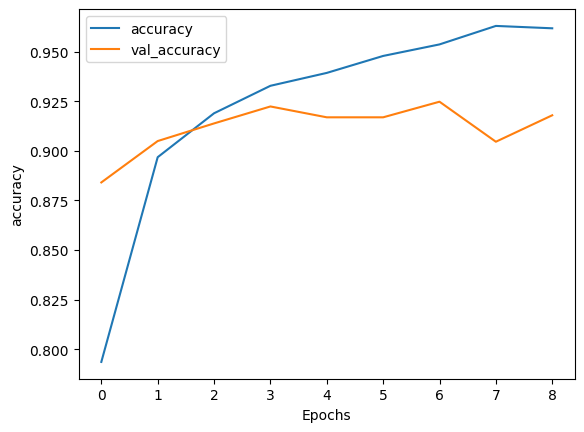

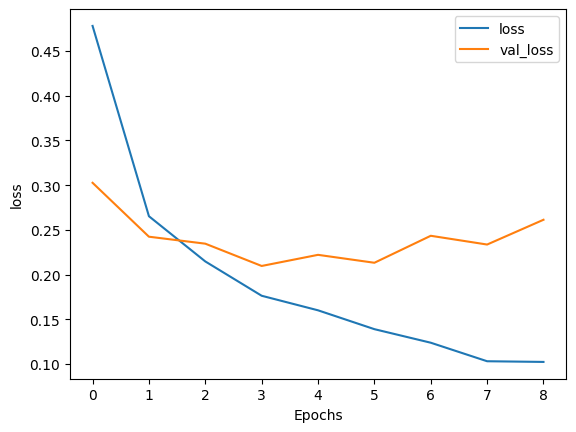

92/92 [==============================] - 1s 6ms/step - loss: 0.2613 - accuracy: 0.9179
Accuracy of the model on Training Data is -  97.10108041763306
Accuracy of the model on Testing Data is -  91.79206490516663
92/92 [==============================] - 1s 6ms/step
Sample Predictions: [[1]
 [0]
 [1]
 [0]
 [1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1327
           1       0.93      0.92      0.92      1597

    accuracy                           0.92      2924
   macro avg       0.92      0.92      0.92      2924
weighted avg       0.92      0.92      0.92      2924

      Real  Hoax
Real  1216   111
Hoax   129  1468


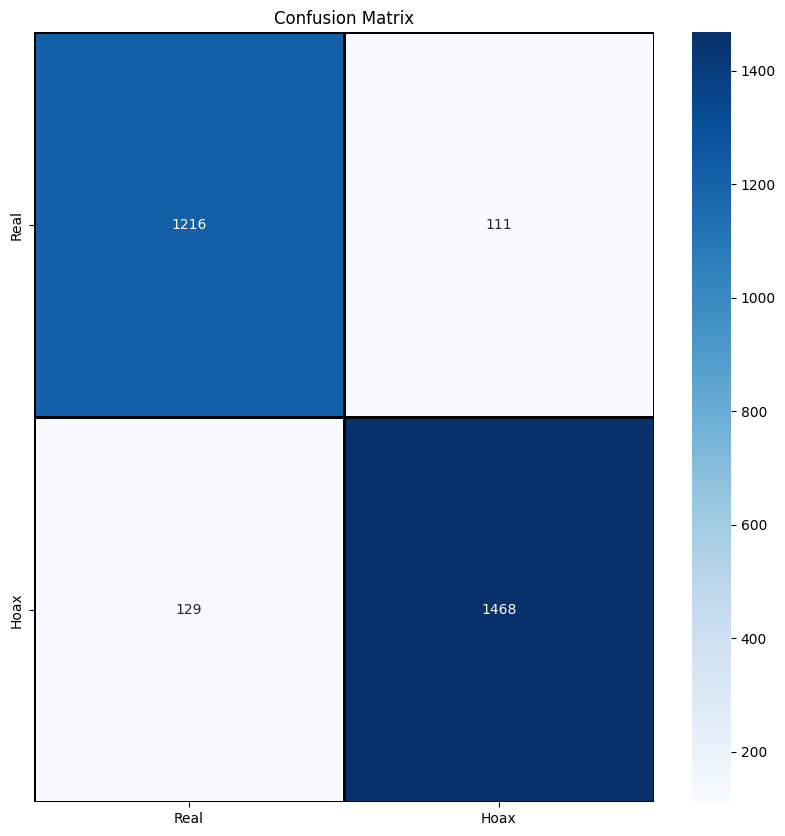

In [ ]:
max_features = 15000
batch_size = 64
epochs = 9
# 10 terlalu banyak , overfitting
embed_size = 50

# Function to build the model
"""## MODEL

### Model 1

*   **Epoch** : 5
*   **Dimension Embedding** : 100
*   **Hidden Layer**  : 64
*   **Batch Size**    : 64
*   **Optimizer**     : Adam
*   **Learning Rate**  : 0.01
"""

def build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate):
    max_features =  15000# Isi dengan nilai sesuai kebutuhan
    maxlen =  30 # Isi dengan nilai sesuai kebutuhan
    # x_train, y_train, X_test, y_test harus sudah didefinisikan sebelumnya

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
        input_dim=max_features,
        output_dim=embedding_dim,  # Adjusted to match the pre-trained embedding dimension
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False  # Optional: Set to True if you want to fine-tune the embeddings
    ),
        #tf.keras.layers.Embedding(input_dim=max_features, output_dim=embed_size, input_length=maxlen),
        tf.keras.layers.LSTM(hidden_layer_size),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    model.summary()

    history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs)

    return history,model

# Contoh pemanggilan fungsi:
#epochs = 5
#embed_size = 50
hidden_layer_size = 64
#batch_size = 64
learning_rate = 0.01

print("Model 1")
# Contoh pemanggilan untuk dua model dengan nama yang berbeda
history,model = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Usage
evaluate_and_visualize(model, x_train, y_train, X_test, y_test)

In [ ]:
import zipfile

In [ ]:
# Example usage
input_sentences = ["anies meninggal dunia", "jokowi minta maaf kepada pki","BPS: Tingkat Pengangguran Februari 2023 Turun 0,38%","CAK NUN SEBUT JOKOWI SEPERTI FIR’AUN KARENA DISURUH",
                   "Beban Utang Prabowo Subianto 7,6 Triliun"]

predictions = predict_sentences(input_sentences, model, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

1/1 [==============================] - 0s 23ms/step
[[0.9977088]
 [0.9426728]
 [0.9001268]
 [0.8333137]
 [0.9876411]]
Sentence: anies meninggal dunia
Prediction: Hoax

Sentence: jokowi minta maaf kepada pki
Prediction: Hoax

Sentence: BPS: Tingkat Pengangguran Februari 2023 Turun 0,38%
Prediction: Hoax

Sentence: CAK NUN SEBUT JOKOWI SEPERTI FIR’AUN KARENA DISURUH
Prediction: Hoax

Sentence: Beban Utang Prabowo Subianto 7,6 Triliun
Prediction: Hoax



In [ ]:
# Example usage
input_sentences = ["foto “selebaran waspada penculikan anak anak berumur polda metro jaya",
                   "dpr aturan disiplin kerja pns terarah",
                   "projo patuh konstitusi sikapi isu penundaan pemilu",
                   "partai ummat menjadi peserta pemilu",
                   "foto “rumah sakit tega meloloskan bapa membawa pulang mayat anaknya sepeda motor"]

predictions = predict_sentences(input_sentences, model, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

1/1 [==============================] - 0s 41ms/step
[[0.99769413]
 [0.01512843]
 [0.00270109]
 [0.01244458]
 [0.9976431 ]]
Sentence: foto “selebaran waspada penculikan anak anak berumur polda metro jaya
Prediction: Hoax

Sentence: dpr aturan disiplin kerja pns terarah
Prediction: Real

Sentence: projo patuh konstitusi sikapi isu penundaan pemilu
Prediction: Real

Sentence: partai ummat menjadi peserta pemilu
Prediction: Real

Sentence: foto “rumah sakit tega meloloskan bapa membawa pulang mayat anaknya sepeda motor
Prediction: Hoax



In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Menyimpan model di luar fungsi
model.save("model_lstm1.h5")
print("Model telah disimpan sebagai 'model_lstm1.h5'.")

Model telah disimpan sebagai 'model_lstm1.h5'.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
# Load pre-trained model and tokenizer

model_load = load_model('model_lstm1.h5')
model.summary()

# Example usage
input_sentences = ["foto “selebaran waspada penculikan anak anak berumur polda metro jaya",
                   "dpr aturan disiplin kerja pns terarah",
                   "projo patuh konstitusi sikapi isu penundaan pemilu",
                   "peserta pemilu partai ummat nomor urut",
                   "foto “rumah sakit tega meloloskan bapa membawa pulang mayat anaknya sepeda motor"]

predictions = predict_sentences(input_sentences, model_load, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            750000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
1/1 [===========

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
# Load pre-trained model and tokenizer

model = load_model('model_lstm1.h5')
model.summary()

# FUNGSI PREDICT TEST KALIMAT
def predict_sentences(sentences, model, tokenizer, max_len):
    # Tokenize and pad the input sentences
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences, padding=PADDING, maxlen=max_len)

    # Make predictions using the model
    predictions = model.predict(padded)

    print(predictions)

    # Convert predictions to binary labels (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)

    return binary_predictions,predictions

predictions = predict_sentences(input_sentences, model, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            750000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
1/1 [===========

In [ ]:
model.save('my_lstm1.keras')

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
# Load pre-trained model and tokenizer

model = load_model('/content/my_lstm1.keras')
#loaded_model = tf.keras.models.load_model('my_model.keras')
model.summary()

# FUNGSI PREDICT TEST KALIMAT
def predict_sentences(sentences, model, tokenizer, max_len):
    # Tokenize and pad the input sentences
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences, padding=PADDING, maxlen=max_len)

    # Make predictions using the model
    predictions = model.predict(padded)

    print(predictions)

    # Convert predictions to binary labels (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)

    return binary_predictions,predictions

predictions = predict_sentences(input_sentences, model, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            750000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
1/1 [===========

### Model 2

Model 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 50)            750000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
Epoch 

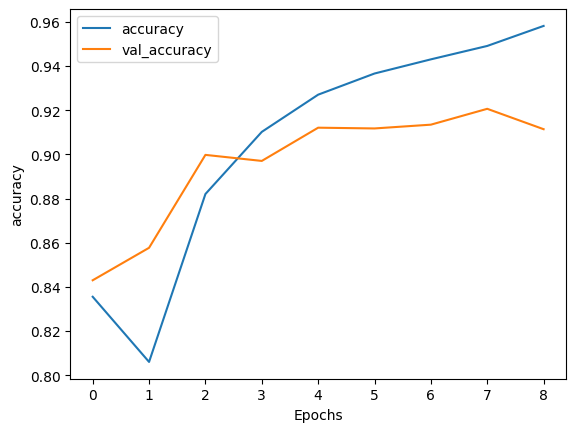

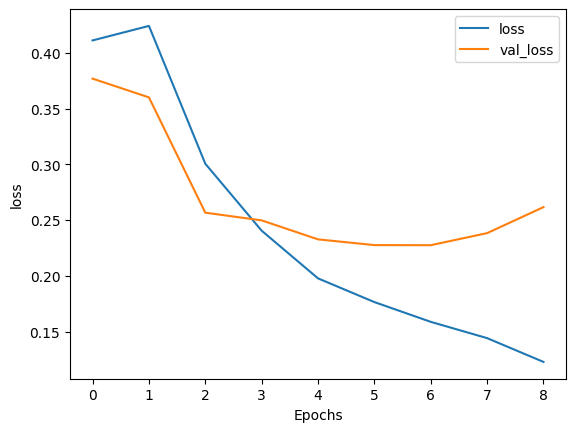

92/92 [==============================] - 1s 7ms/step - loss: 0.2616 - accuracy: 0.9114
Accuracy of the model on Training Data is -  96.12621665000916
Accuracy of the model on Testing Data is -  91.14227294921875


92/92 [==============================] - 1s 6ms/step
Sample Predictions: [[1]
 [0]
 [1]
 [1]
 [1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.90      1327
           1       0.89      0.96      0.92      1597

    accuracy                           0.91      2924
   macro avg       0.92      0.91      0.91      2924
weighted avg       0.91      0.91      0.91      2924

      Real  Hoax
Real  1134   193
Hoax    66  1531


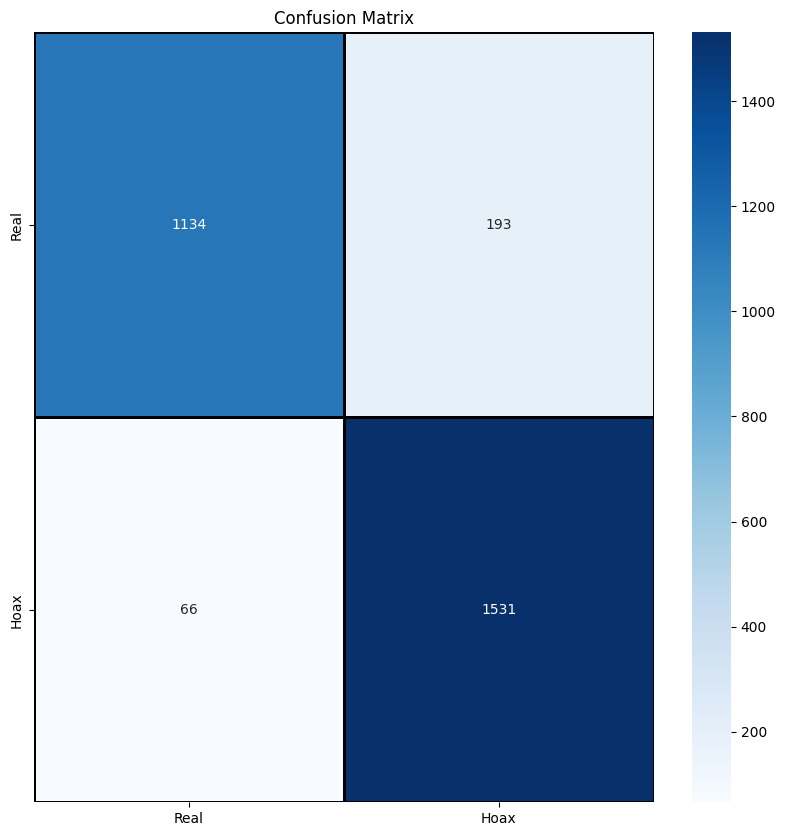

1/1 [==============================] - 0s 22ms/step
[[0.99535954]
 [0.00380451]
 [0.00405251]
 [0.00735932]
 [0.9980408 ]]
Sentence: foto “selebaran waspada penculikan anak anak berumur polda metro jaya
Prediction: Hoax

Sentence: dpr aturan disiplin kerja pns terarah
Prediction: Real



In [ ]:
"""### Model 2

*   **Epoch** : 5
*   **Dimension Embedding** : 100
*   **Hidden Layer**  : 64
*   **Batch Size**    : 64
*   **Optimizer**     : Adam
*   **Learning Rate**  : 0.001

"""

#epochs = 5
#embed_size = 50
hidden_layer_size = 64
batch_size = 64
learning_rate = 1e-2

print("Model 2")
history2,model2 = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

# Usage
evaluate_and_visualize(model2, x_train, y_train, X_test, y_test)

# Example usage

predictions = predict_sentences(input_sentences, model2, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

### Model 3

Model 3
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 50)            750000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
Epoch 

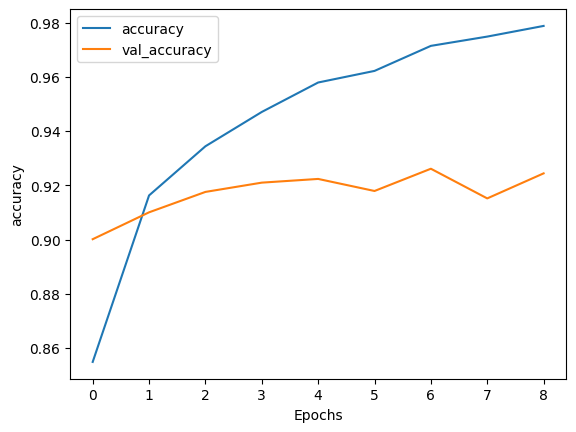

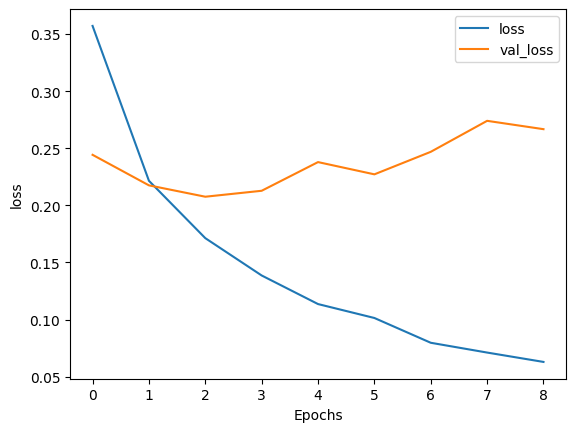

92/92 [==============================] - 1s 11ms/step - loss: 0.2667 - accuracy: 0.9244
Accuracy of the model on Training Data is -  98.93962740898132
Accuracy of the model on Testing Data is -  92.44186282157898
92/92 [==============================] - 1s 7ms/step
Sample Predictions: [[1]
 [0]
 [1]
 [0]
 [1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1327
           1       0.92      0.94      0.93      1597

    accuracy                           0.92      2924
   macro avg       0.93      0.92      0.92      2924
weighted avg       0.92      0.92      0.92      2924

      Real  Hoax
Real  1195   132
Hoax    89  1508


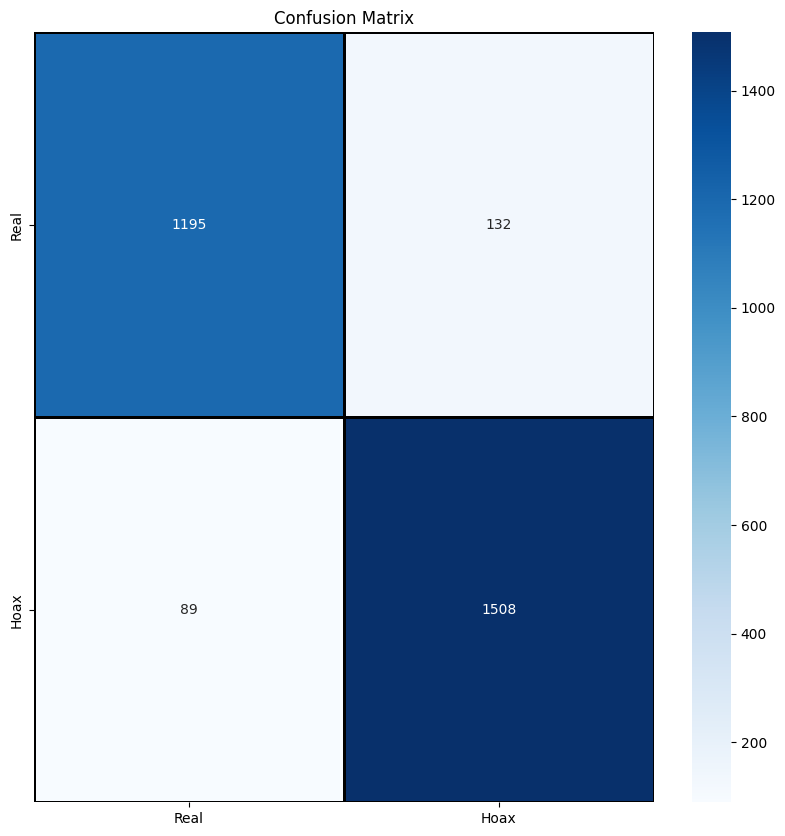

1/1 [==============================] - 0s 23ms/step
[[0.99882597]
 [0.00799531]
 [0.0020063 ]
 [0.20805398]
 [0.99851906]]
Sentence: foto “selebaran waspada penculikan anak anak berumur polda metro jaya
Prediction: Hoax

Sentence: dpr aturan disiplin kerja pns terarah
Prediction: Real



In [ ]:
#epochs = 5
#embed_size = 100
hidden_layer_size = 64
batch_size = 64
optimizer = 'Adam'
learning_rate = 1e-3

print("Model 3")
history3,model3 = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")

# Usage
evaluate_and_visualize(model3, x_train, y_train, X_test, y_test)

# Example usage

predictions = predict_sentences(input_sentences, model3, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

### Model 4

Model 4
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 50)            750000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
Epoch 

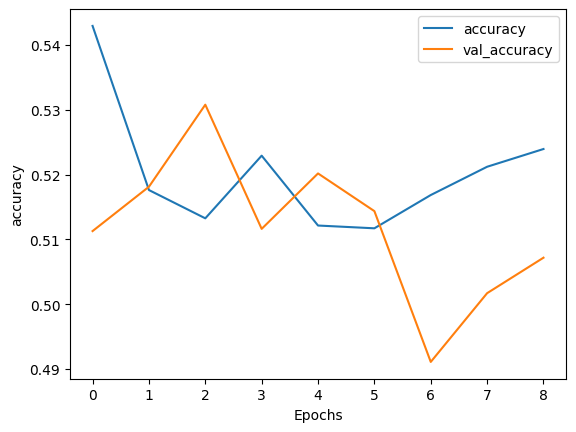

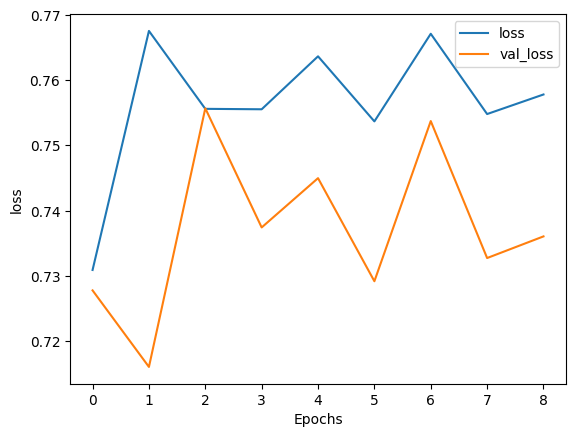

92/92 [==============================] - 1s 10ms/step - loss: 0.7360 - accuracy: 0.5072
Accuracy of the model on Training Data is -  51.76158547401428
Accuracy of the model on Testing Data is -  50.718194246292114
92/92 [==============================] - 1s 9ms/step
Sample Predictions: [[1]
 [1]
 [1]
 [0]
 [0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.37      0.41      1327
           1       0.54      0.62      0.58      1597

    accuracy                           0.51      2924
   macro avg       0.50      0.50      0.49      2924
weighted avg       0.50      0.51      0.50      2924

      Real  Hoax
Real   493   834
Hoax   607   990


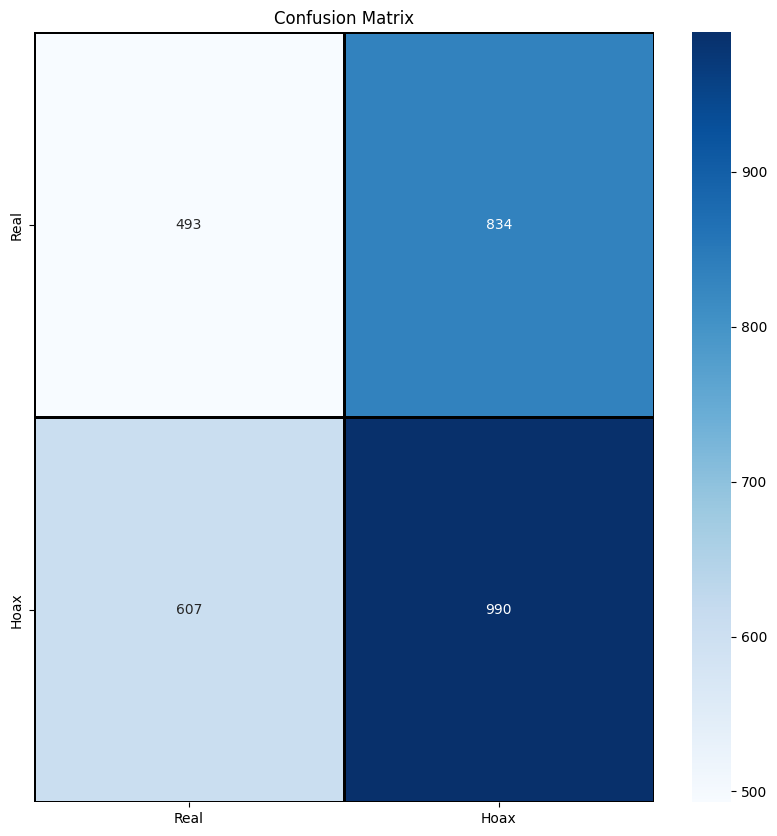

In [ ]:
#epochs = 5
#embed_size = 100
hidden_layer_size = 64
batch_size = 32
optimizer = 'Adam'
learning_rate = 1e-1

print("Model 4")
history4,model4 = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history4, "accuracy")
plot_graphs(history4, "loss")

# Usage
evaluate_and_visualize(model4, x_train, y_train, X_test, y_test)


In [ ]:
# Example usage

predictions = predict_sentences(input_sentences, model4, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

1/1 [==============================] - 0s 35ms/step
[[0.500298  ]
 [0.51390785]
 [0.5151933 ]
 [0.5349596 ]
 [0.52683794]]
Sentence: foto “selebaran waspada penculikan anak anak berumur polda metro jaya
Prediction: Hoax

Sentence: dpr aturan disiplin kerja pns terarah
Prediction: Real



### Model 5

Model 5
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 50)            750000    
                                                                 
 lstm_4 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
Epoch 

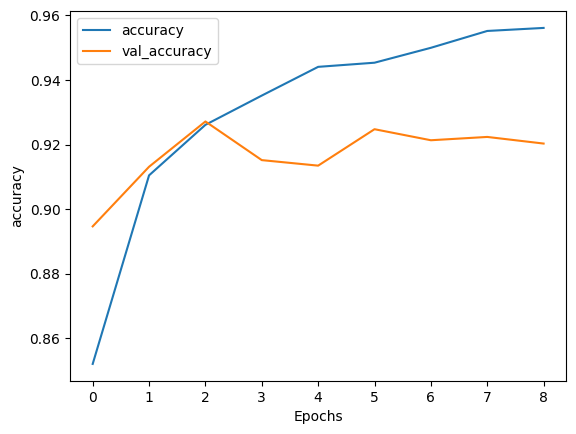

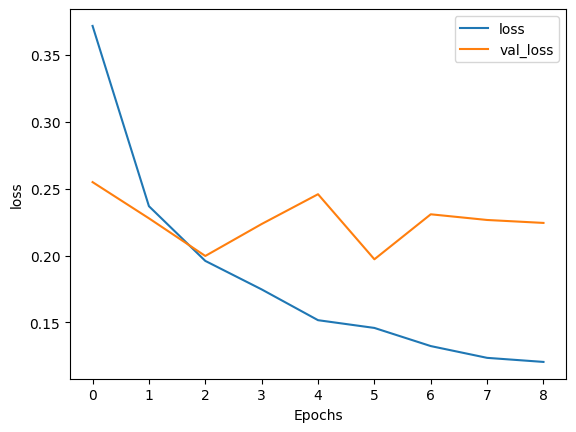

92/92 [==============================] - 1s 6ms/step - loss: 0.2243 - accuracy: 0.9203
Accuracy of the model on Training Data is -  96.64785265922546
Accuracy of the model on Testing Data is -  92.0314610004425
92/92 [==============================] - 2s 6ms/step
Sample Predictions: [[1]
 [0]
 [1]
 [0]
 [1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1327
           1       0.92      0.94      0.93      1597

    accuracy                           0.92      2924
   macro avg       0.92      0.92      0.92      2924
weighted avg       0.92      0.92      0.92      2924

      Real  Hoax
Real  1188   139
Hoax    94  1503


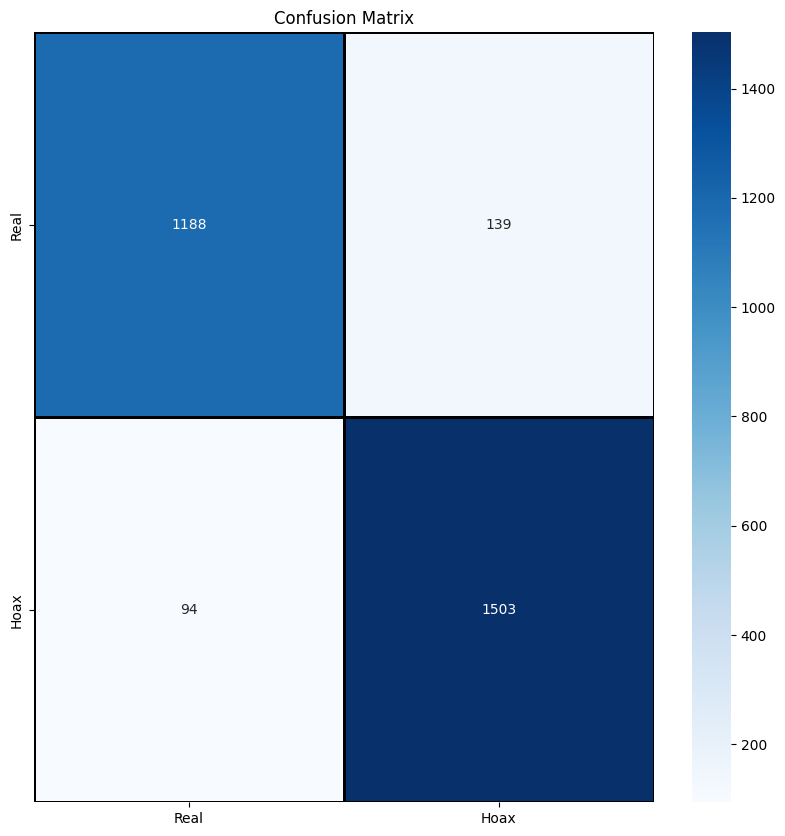

1/1 [==============================] - 0s 35ms/step
[[0.991087  ]
 [0.00909293]
 [0.00293847]
 [0.04569985]
 [0.9970745 ]]
Sentence: foto “selebaran waspada penculikan anak anak berumur polda metro jaya
Prediction: Hoax

Sentence: dpr aturan disiplin kerja pns terarah
Prediction: Real



In [ ]:
#epochs = 5
#embed_size = 100
hidden_layer_size = 64
batch_size = 32
optimizer = 'Adam'
learning_rate = 1e-2

print("Model 5")
history5,model5 = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history5, "accuracy")
plot_graphs(history5, "loss")

# Usage
evaluate_and_visualize(model5, x_train, y_train, X_test, y_test)

# Example usage

predictions = predict_sentences(input_sentences, model5, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

### Model 6

Model 6
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 50)            750000    
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
Epoch 

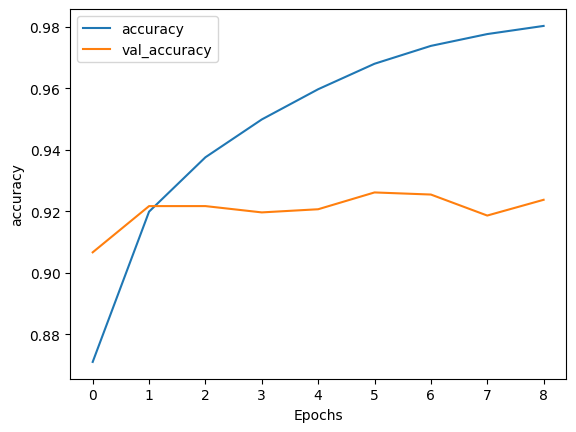

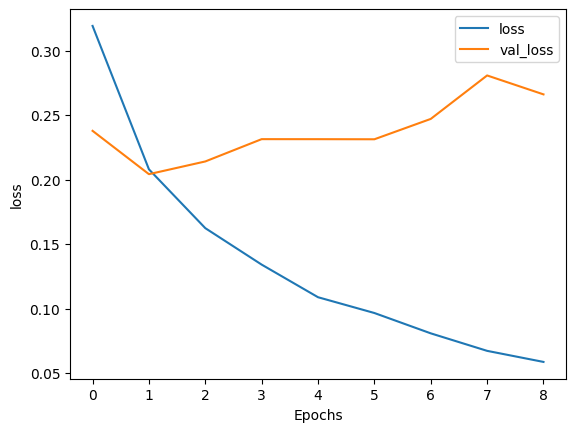

92/92 [==============================] - 1s 9ms/step - loss: 0.2661 - accuracy: 0.9237
Accuracy of the model on Training Data is -  98.99948835372925
Accuracy of the model on Testing Data is -  92.37346053123474
92/92 [==============================] - 1s 8ms/step
Sample Predictions: [[1]
 [0]
 [1]
 [0]
 [1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1327
           1       0.93      0.93      0.93      1597

    accuracy                           0.92      2924
   macro avg       0.92      0.92      0.92      2924
weighted avg       0.92      0.92      0.92      2924

      Real  Hoax
Real  1220   107
Hoax   116  1481


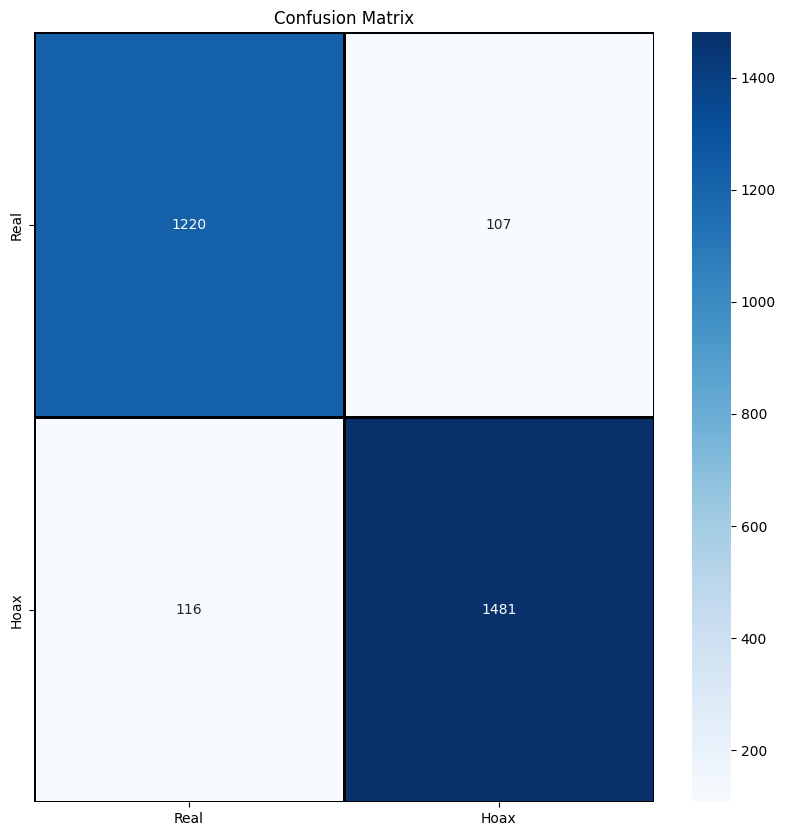

1/1 [==============================] - 0s 22ms/step
[[0.9954848 ]
 [0.00212739]
 [0.00205878]
 [0.00531792]
 [0.9980469 ]]
Sentence: foto “selebaran waspada penculikan anak anak berumur polda metro jaya
Prediction: Hoax

Sentence: dpr aturan disiplin kerja pns terarah
Prediction: Real



In [ ]:
#epochs = 5
#embed_size = 100
hidden_layer_size = 64
batch_size = 32
optimizer = 'Adam'
learning_rate = 1e-3

print("Model 6")
history6,model6 = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history6, "accuracy")
plot_graphs(history6, "loss")

# Usage
evaluate_and_visualize(model6, x_train, y_train, X_test, y_test)

# Example usage

predictions = predict_sentences(input_sentences, model6, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")


## Test Kode Real Label == Predict Label

In [ ]:
import pandas as pd

# Membaca file CSV ke dalam DataFrame
df_result = pd.read_csv("/content/df_data_test.csv")

# Misalnya, sentences adalah kolom 'Text' pada DataFrame
sentences = df_result['Text']

max_len = 30

# Anda perlu mendefinisikan fungsi predict_sentences, model, dan tokenizer
# Sebagai contoh sederhana, kita mendefinisikan predict_sentences sebagai fungsi yang mengembalikan daftar prediksi dummy
def predict_sentences(sentences, model, tokenizer, max_len):
    # Implementasi prediksi dummy (Anda harus menggantinya dengan prediksi sebenarnya)
    predictions = [0] * len(sentences)
    return predictions

# Mengganti fungsi predict_sentences dengan model dan tokenizer yang sesuai
model = None  # Anda harus mengganti ini dengan model Anda
tokenizer = None  # Anda harus mengganti ini dengan tokenizer Anda

binary_predictions = predict_sentences(sentences, model, tokenizer, max_len)

# Menambahkan kolom 'predicted_label' ke DataFrame
df_result['predicted_label'] = binary_predictions

# Menambahkan kolom 'is_correct' yang berisi label true jika 'predicted_label' sama dengan 'true_label'
df_result['is_correct'] = df_result['predicted_label'] == df_result['True_Label']

# Menampilkan DataFrame
print(df_result)


                                                   Text  True_Label  \
0        akun whatsapp wakil bupati bantul nomor donasi           1   
1     koalisi perubahan cari istilah milenial nama s...           0   
2       peringatan pemblokiran tim pemblokiran facebook           1   
3     apdesi surta wijaya dukung jokowi periode angg...           0   
4            video rapat program buka puasa dki jakarta           1   
...                                                 ...         ...   
2919  pilpres pengamat capres berpotensi melanjutkan...           0   
2920  presiden putin peringati jokowi campur rusia u...           1   
2921  dudung abdurachman pastikan pernyataan liar ef...           0   
2922                                   paku kapsul obat           1   
2923                                       foto meleleh           1   

      predicted_label  is_correct  
0                   0       False  
1                   0        True  
2                   0       False  
3  

In [ ]:
df_result

,Text,True_Label,predicted_label,is_correct
0,akun whatsapp wakil bupati bantul nomor donasi,1,0,False
1,koalisi perubahan cari istilah milenial nama s...,0,0,True
2,peringatan pemblokiran tim pemblokiran facebook,1,0,False
3,apdesi surta wijaya dukung jokowi periode angg...,0,0,True
4,video rapat program buka puasa dki jakarta,1,0,False
...,...,...,...,...
2919,pilpres pengamat capres berpotensi melanjutkan...,0,0,True
2920,presiden putin peringati jokowi campur rusia u...,1,0,False
2921,dudung abdurachman pastikan pernyataan liar ef...,0,0,True
2922,paku kapsul obat,1,0,False


In [ ]:
import pandas as pd

# Membaca file CSV ke dalam DataFrame
#df_result = pd.read_csv("/content/df_data_test.csv")

# Pastikan Anda sudah memiliki kolom 'True_Label' dan 'predicted_label' pada DataFrame
# Anda bisa menambahkan kolom 'is_correct' dengan membandingkan 'True_Label' dan 'predicted_label'
df_result['is_correct'] = df_result['True_Label'] == df_result['predicted_label']

# Menghitung jumlah label true dan false dari kolom 'is_correct'
label_counts = df_result['is_correct'].value_counts()

# Menampilkan hasil
print("Jumlah label True:", label_counts[True])
print("Jumlah label False:", label_counts[False])

Jumlah label True: 1327
Jumlah label False: 1597


In [ ]:
# Misalkan Anda sudah mempunyai DataFrame df_result
# df_result = ...

# Menampilkan data di mana label asli adalah 0 tetapi diprediksi 1
false_positive = df_result[(df_result['True_Label'] == 0) & (df_result['predicted_label'] == 1)]

# Menampilkan data di mana label asli adalah 1 tetapi diprediksi 0
false_negative = df_result[(df_result['True_Label'] == 1) & (df_result['predicted_label'] == 0)]

# Menampilkan hasil
print("Data False Positive:")
false_positive

print("\nData False Negative:")
false_negative

Data False Positive:

Data False Negative:


,Text,True_Label,predicted_label,is_correct
0,akun whatsapp wakil bupati bantul nomor donasi,1,0,False
2,peringatan pemblokiran tim pemblokiran facebook,1,0,False
4,video rapat program buka puasa dki jakarta,1,0,False
5,pinjaman online kospin jasa pesan whatsapp,1,0,False
8,keluarga gusdur mendukung penuh calon president,1,0,False
...,...,...,...,...
2915,kpk lakukan ott dokter gigi surabaya berkaitan...,1,0,False
2916,hadapi ancaman stm pakar intelejen densus ting...,1,0,False
2920,presiden putin peringati jokowi campur rusia u...,1,0,False
2922,paku kapsul obat,1,0,False


In [ ]:
print("\nData False Negative:")
false_negative


Data False Negative:


,Text,True_Label,predicted_label,is_correct
0,akun whatsapp wakil bupati bantul nomor donasi,1,0,False
2,peringatan pemblokiran tim pemblokiran facebook,1,0,False
4,video rapat program buka puasa dki jakarta,1,0,False
5,pinjaman online kospin jasa pesan whatsapp,1,0,False
8,keluarga gusdur mendukung penuh calon president,1,0,False
...,...,...,...,...
2915,kpk lakukan ott dokter gigi surabaya berkaitan...,1,0,False
2916,hadapi ancaman stm pakar intelejen densus ting...,1,0,False
2920,presiden putin peringati jokowi campur rusia u...,1,0,False
2922,paku kapsul obat,1,0,False


In [ ]:
# Misalkan df_result adalah DataFrame Anda
# df_result = ...

# Reset index
df_result = df_result.reset_index(drop=True)

# Menampilkan DataFrame setelah direset index
print(df_result)

                                                   Text  True_Label  \
0        akun whatsapp wakil bupati bantul nomor donasi           1   
1     koalisi perubahan cari istilah milenial nama s...           0   
2       peringatan pemblokiran tim pemblokiran facebook           1   
3     apdesi surta wijaya dukung jokowi periode angg...           0   
4            video rapat program buka puasa dki jakarta           1   
...                                                 ...         ...   
2919  pilpres pengamat capres berpotensi melanjutkan...           0   
2920  presiden putin peringati jokowi campur rusia u...           1   
2921  dudung abdurachman pastikan pernyataan liar ef...           0   
2922                                   paku kapsul obat           1   
2923                                       foto meleleh           1   

      predicted_label  is_correct  
0                   0       False  
1                   0        True  
2                   0       False  
3  

In [ ]:
# Menyimpan DataFrame yang sudah diperbarui
df_result.to_csv('df_result_updated.csv', index=False)  # Gantilah dengan nama file dan path yang sesuai